<img src="https://raw.githubusercontent.com/NCAR/dask-tutorial/main/images/NCAR-contemp-logo-blue.png"
     width="750px"
     alt="NCAR logo"
     style="vertical-align:middle;margin:30px 0px"/>

# Dask DataFrame


**ESDS dask tutorial | 06 February, 2023**  

Negin Sobhani, Brian Vanderwende, Deepak Cherian, Ben Kirk  
Computational & Information Systems Lab (CISL)  
[negins@ucar.edu](mailto:negins@ucar.edu), [vanderwb@ucar.edu](mailto:vanderwb@ucar.edu)

---------
### In this tutorial, you learn:

* Basic concepts and features of Dask DataFrames
* Applications of Dask DataFrames
* Interacting with Dask DataFrames
* Built-in operations with Dask DataFrames
* Dask DataFrames Best Practices

### Related Documentation

* [Dask DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html)
* [Dask DataFrame API](https://docs.dask.org/en/latest/dataframe-api.html)
* [Dask DataFrame examples](https://examples.dask.org/dataframe.html)
* [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)


---------

## Introduction


<img src="https://raw.githubusercontent.com/NCAR/dask-tutorial/main/images/dask_dataframe.png"
     align="right"
     width="530px"
     alt="Dask DataFrame is composed of pandas DataFrames"/>
     
     

pandas is a very popular tool for working with **tabular datasets**, but the dataset needs to **fit into the memory**. 

pandas operates best with smaller datasets, and if you have a large dataset, you’ll receive an out of memory error using pandas. A general rule of thumb for pandas is:

> "Have 5 to 10 times as much RAM as the size of your dataset"
>
> ~ Wes McKinney (2017) in [10 things I hate about pandas](https://wesmckinney.com/blog/apache-arrow-pandas-internals/)

But Dask DataFrame can be used to solve pandas performance issues with larger-than-memory datasets.


### What is Dask DataFrame?


* **A Dask DataFrame is a parallel DataFrame composed of smaller pandas DataFrames (also known as *partitions*).**

* Dask Dataframes look and feel like the pandas DataFrames on the surface. 

* Dask DataFrames partition the data into manageable **partitions** that can be processed in parallel and across multiple cores or computers. 

* Similar to Dask Arrays, Dask DataFrames are lazy!

    Unlike pandas, operations on Dask DataFrames are not computed until you explicitly request them (e.g. by calling `.compute`).



## When to use Dask DataFrame and when to avoid it?

Dask DataFrames are used in situations where pandas *fails* or has *poor performance due to data size*.  

Dask DataFrame is a good choice when doing **parallalizeable computations**.  
Some examples are:
* Element-wise operations such as `df.x + df.y`
* Row-wise filtering such as `df[df.x>0]`
* Common aggregations such as `df.x.max()`
* Dropping duplicates such as `df.x.drop_duplicate()`

However, Dask is not great for operations that requires shuffling or re-indexing.  
Some examples are:
* Set index: `df.set_index(df.x)`


 
<div class="alert alert-block alert-warning" markdown="1">
<b>WARNING:</b> Although, Dask DataFrame has a very similar interface to the pandas DataFrame (as we will see in this tutorial), it does NOT include some of the pandas interface yet.

See the [Dask DataFrame API documentation](https://docs.dask.org/en/stable/dataframe-api.html) for a compehnsive list of available functions. 
</div>


--------------------

## Tutorial Dataset
In this tutorial, we are going to use the NOAA Global Historical Climatology Network Daily (GHCN-D) dataset.  
GHCN-D is a public available dataset that includes daily climate records from +100,000 surface observations around the world.  
This is an example of a real dataset that is used by NCAR scientists for their research. GHCN-D raw dataset for all stations is available through [NOAA Climate Data Online](https://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND). 

**To learn more about GHCNd dataset, please visit:**
* [GHCNd Journal Paper](https://journals.ametsoc.org/view/journals/atot/29/7/jtech-d-11-00103_1.xml)
* [GHCNd Official Website](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily)

### Download the data
For this example, we are going to look through a subset of data from the GHCN-D dataset.

First, we look at the daily observations from Denver International Airport, next we are going to look through selected stations in the US. 

The access the preprocessed dataset for this tutorial, please run the following script:

In [1]:
!./get_data.sh

--2023-02-05 13:50:53--  https://docs.google.com/uc?export=download&id=14doSRn8hT14QYtjZz28GKv14JgdIsbFF
Resolving docs.google.com... 142.250.72.78, 2607:f8b0:400f:807::200e
Connecting to docs.google.com|142.250.72.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hkbhr7uhov17jj84626eu6oouerldgvu/1675630200000/12706685253353286515/*/14doSRn8hT14QYtjZz28GKv14JgdIsbFF?e=download&uuid=8c5eb41b-5044-4497-8562-d31dc9d3bc4d [following]
--2023-02-05 13:51:05--  https://doc-08-74-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hkbhr7uhov17jj84626eu6oouerldgvu/1675630200000/12706685253353286515/*/14doSRn8hT14QYtjZz28GKv14JgdIsbFF?e=download&uuid=8c5eb41b-5044-4497-8562-d31dc9d3bc4d
Resolving doc-08-74-docs.googleusercontent.com... 142.250.72.33, 2607:f8b0:400f:804::2001
Connecting to doc-08-74-docs.googleusercontent.com|142.250.72.33|:443... c

This script should save the preprocessed GHCN-D data in `../data` path.


-----------
## Pandas DataFrame Basics
Let's start with an example using pandas DataFrame.

First, let's read in the comma-seperated GHCN-D dataset for one station at **Denver International Airport (DIA), CO** (site ID : `USW00003017`).

To see the list of all available GHCN-D sites and their coordinates and IDs, please see [this link](https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt).

In [1]:
import os
import pandas as pd

# DIA ghcnd id
site = 'USW00003017'
data_dir = '../data/'


df = pd.read_csv(os.path.join(data_dir, site+'.csv'), parse_dates=['DATE'], index_col=0)

In [2]:
# Display the top five rows of the dataframe
df.head()

,ID,YEAR,MONTH,DAY,TMAX,TMAX_FLAGS,TMIN,TMIN_FLAGS,PRCP,PRCP_FLAGS,...,RHMN_FLAGS,RHMX,RHMX_FLAGS,PSUN,PSUN_FLAGS,LATITUDE,LONGITUDE,ELEVATION,STATE,STATION
DATE,,,,,,,,,,,,,,,,,,,,,
1994-07-20,USW00003017,1994,7,20,316.0,XXS,150.0,XXS,20.0,DXS,...,XXX,NaN,XXX,NaN,XXX,39.8467,-104.6561,1647.1,CO,DENVER INTL AP
1994-07-23,USW00003017,1994,7,23,355.0,XXS,166.0,XXS,0.0,DXS,...,XXX,NaN,XXX,NaN,XXX,39.8467,-104.6561,1647.1,CO,DENVER INTL AP
1994-07-24,USW00003017,1994,7,24,333.0,XXS,155.0,XXS,81.0,DXS,...,XXX,NaN,XXX,NaN,XXX,39.8467,-104.6561,1647.1,CO,DENVER INTL AP
1994-07-25,USW00003017,1994,7,25,327.0,XXS,172.0,XXS,0.0,DXS,...,XXX,NaN,XXX,NaN,XXX,39.8467,-104.6561,1647.1,CO,DENVER INTL AP
1994-07-26,USW00003017,1994,7,26,327.0,XXS,155.0,XXS,0.0,DXS,...,XXX,NaN,XXX,NaN,XXX,39.8467,-104.6561,1647.1,CO,DENVER INTL AP


**Question:** What variables are available?

In [3]:
df.columns

Index(['ID', 'YEAR', 'MONTH', 'DAY', 'TMAX', 'TMAX_FLAGS', 'TMIN',
       'TMIN_FLAGS', 'PRCP', 'PRCP_FLAGS', 'TAVG', 'TAVG_FLAGS', 'SNOW',
       'SNOW_FLAGS', 'SNWD', 'SNWD_FLAGS', 'AWND', 'AWND_FLAGS', 'FMTM',
       'FMTM_FLAGS', 'PGTM', 'PGTM_FLAGS', 'WDF2', 'WDF2_FLAGS', 'WDF5',
       'WDF5_FLAGS', 'WSF2', 'WSF2_FLAGS', 'WSF5', 'WSF5_FLAGS', 'WT01',
       'WT01_FLAGS', 'WT02', 'WT02_FLAGS', 'WT08', 'WT08_FLAGS', 'WT16',
       'WT16_FLAGS', 'WT17', 'WT17_FLAGS', 'WT18', 'WT18_FLAGS', 'WT03',
       'WT03_FLAGS', 'WT05', 'WT05_FLAGS', 'WT19', 'WT19_FLAGS', 'WT10',
       'WT10_FLAGS', 'WT09', 'WT09_FLAGS', 'WT06', 'WT06_FLAGS', 'WT07',
       'WT07_FLAGS', 'WT11', 'WT11_FLAGS', 'WT13', 'WT13_FLAGS', 'WT21',
       'WT21_FLAGS', 'WT14', 'WT14_FLAGS', 'WT15', 'WT15_FLAGS', 'WT22',
       'WT22_FLAGS', 'WT04', 'WT04_FLAGS', 'WV03', 'WV03_FLAGS', 'TSUN',
       'TSUN_FLAGS', 'WV01', 'WV01_FLAGS', 'WESD', 'WESD_FLAGS', 'ADPT',
       'ADPT_FLAGS', 'ASLP', 'ASLP_FLAGS', 'ASTP', 'ASTP_

The description and units of the dataset is available [here](https://www.ncei.noaa.gov/pub/data/ghcn/daily/readme.txt).  

### Operations on pandas DataFrame

pandas DataFrames has several features that give us flexibility to do different calculations and analysis on our dataset. Let's check some out:
#### Simple Analysis


For example: 
* When was the coldest day at this station during December of last year?

In [4]:
# use python slicing notation inside .loc 
# use idxmin() to find the index of minimum valus
df.loc['2022-12-01':'2022-12-31'].TMIN.idxmin()

Timestamp('2022-12-22 00:00:00')

<AxesSubplot:xlabel='DATE', ylabel='Daily Average Snow Depth [mm]'>

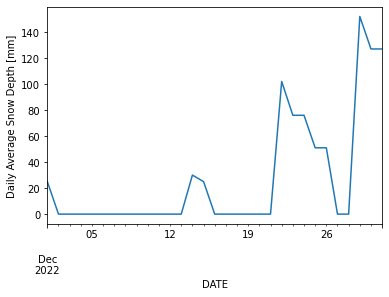

In [8]:
# Here we easily plot the prior data using matplotlib from pandas
# -- .loc for value based indexing
df.loc['2022-12-01':'2022-12-31'].SNWD.plot(ylabel= 'Daily Average Snow Depth [mm]')

* How many snow days do we have each year at this station?

Pandas groupby is used for grouping the data according to the categories.

In [6]:
# 1- First select days with snow > 0
# 2- Create a "groupby object" based on the selected columns
# 3- use .size() to compute the size of each group
# 4- sort the values descending 

# we count days where SNOW>0, and sort them and show top 5 years:
df[df['SNOW']>0].groupby('YEAR').size().sort_values(ascending=False).head()


YEAR
2015    36
2019    34
2014    32
2008    32
2007    31
dtype: int64

Or for a more complex analysis:

For example, we have heard that this could be Denver's first January in 13 years with no 60-degree days.  





<img src="https://raw.githubusercontent.com/NCAR/dask-tutorial/main/images/denver2.png"
     alt="Dask DataFrame is composed of pandas DataFrames"/>

Below, we show all days with high temperature above 60°F (155.5°C/10) since 2010:

In [7]:
df[(df['MONTH']==1) & (df['YEAR']>=2010) & (df['TMAX']>155.5)].groupby(['YEAR']).size()

YEAR
2011    1
2012    6
2013    4
2014    3
2015    6
2016    1
2017    4
2018    5
2019    3
2020    2
2021    2
2022    3
dtype: int64

This is great! But how big is this dataset for one station?

First, let's check the file size:

In [8]:
!ls -lh ../data/USW00003017.csv

-rw-r--r-- 1 negins ncar 3.6M Feb  5 07:14 ../data/USW00003017.csv


Similar to the previous tutorial, we can use the following function to find the size of a variable on memory.

In [9]:
# Define function to display variable size in MB
import sys
def var_size(in_var):
    result = sys.getsizeof(in_var) / 1e6
    print(f"Size of variable: {result:.2f} MB")

In [10]:
var_size(df)

Size of variable: 33.21 MB


Remember, the above rule?

> "Have 5 to 10 times as much RAM as the size of your dataset"
>
> ~ Wes McKinney (2017) in [10 things I hate about pandas](https://wesmckinney.com/blog/apache-arrow-pandas-internals/)


**So far, we read in and analyzed data for one station. We have a total of +118,000 stations over the world and +4500 stations in Colorado alone!**

**What if we want to look at the larger dataset?**

## Scaling up to a larger dataset

Let's start by reading data from selected stations. The downloaded data for this example includes the climatology observations from 66 selected sites in Colorado.

Pandas can concatenate data to load data spread across multiple files:


In [11]:
!du -csh ../data/*.csv |tail -n1

566M	total


Using a for loop with `pandas.concat`, we can read multiple files at the same time:

In [12]:
%%time
import glob
co_sites = glob.glob(os.path.join(data_dir, '*.csv'))
df = pd.concat(pd.read_csv(f, index_col=0, parse_dates=['DATE']) for f in co_sites)

CPU times: user 11.9 s, sys: 2.87 s, total: 14.8 s
Wall time: 19.5 s


* How many stations have we read in?

In [13]:
print ("Concatenated data for", len(df.ID.unique()), "unique sites.")

Concatenated data for 66 unique sites.


Now that we concatenated the data for all sites in one DataFrame, we can do similar analysis on it:

* Which site has recorded the most snow days in a year?

In [14]:
%%time
# ~90s on 4GB RAM
snowy_days = df[df['SNOW']>0].groupby(['ID','YEAR']).size()

print ('This site has the highest number of snow days in a year : ')
snowy_days.agg(['idxmax','max'])

This site has the highest number of snow days in a year : 
CPU times: user 4.49 s, sys: 15.4 s, total: 19.9 s
Wall time: 1min 21s


idxmax    (USC00052281, 1983)
max                       102
dtype: object

**Excersise:** Which Colorado site has recorded the most snow days in 2023?

**Dask allows us to conceptualize all of these files as a single dataframe!**

In [15]:
# Let's do a little cleanup
del df, snowy_days

## Computations on Dask DataFrame

### Create a "LocalCluster" Client with Dask

In [18]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 4.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38113,Workers: 4
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 4.00 GiB
Comm: tcp://127.0.0.1:35345,Total threads: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/40352/status,Memory: 1.00 GiB
Nanny: tcp://127.0.0.1:44090,


☝️ Click the Dashboard link above.

👈 Or click the “Search” 🔍 button in the dask-labextension dashboard.

### Dask DataFrame `read_csv` to read multiple files

`dask.dataframe.read_csv` function can be used in conjunction with `glob` to read multiple csv files at the same time. 

Remember we can read one file with `pandas.read_csv`. For reading multiple files with pandas, we have to concatenate them with `pd.concatenate`. However, we can read many files at once just using `dask.dataframe.read_csv`.

Overall, Dask is designed to perform I/O in parallel and is more performant than pandas for operations with multiple files or large files.

In [19]:
%%time
import dask
import dask.dataframe as dd

ddf = dd.read_csv(co_sites, parse_dates=['DATE'])
ddf

CPU times: user 462 ms, sys: 123 ms, total: 585 ms
Wall time: 849 ms


,DATE,ID,YEAR,MONTH,DAY,TMAX,TMAX_FLAGS,TMIN,TMIN_FLAGS,PRCP,PRCP_FLAGS,SNOW,SNOW_FLAGS,SNWD,SNWD_FLAGS,WT16,WT16_FLAGS,WT14,WT14_FLAGS,WT18,WT18_FLAGS,TOBS,TOBS_FLAGS,WT01,WT01_FLAGS,WT08,WT08_FLAGS,WT03,WT03_FLAGS,WT04,WT04_FLAGS,WT06,WT06_FLAGS,WT05,WT05_FLAGS,DAPR,DAPR_FLAGS,MDPR,MDPR_FLAGS,WT11,WT11_FLAGS,SN02,SN02_FLAGS,SX02,SX02_FLAGS,SN32,SN32_FLAGS,SX32,SX32_FLAGS,SN52,SN52_FLAGS,SX52,SX52_FLAGS,LATITUDE,LONGITUDE,ELEVATION,STATE,STATION
npartitions=66,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],object,int64,int64,int64,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,object,float64,float64,float64,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [20]:
ddf.TMAX.mean()

dd.Scalar<series-..., dtype=float64>

**Notice that the representation of the DataFrame object contains no data just headers and datatypes.  Why?**

#### Lazy Evaluation

Similar to Dask Arrays, Dask DataFrames are lazy. Here the data has not yet been read into the dataframe yet (a.k.a. lazy evaluation).  
Dask just construct the task graph of the computation but it will "evaluate" them only when necessary.

**So how does Dask know the name and dtype of each column?**

Dask has just read the start of the first file and infers the column names and dtypes. 

Unlike `pandas.read_csv` that reads in all files before inferring data types, `dask.dataframe.read_csv` only reads in a sample from the beginning of the file (or first file if using a glob). The column names and dtypes are then enforced when reading the specific partitions (*Dask can make mistakes on these inferences if there is missing or misleading data in the early rows*).

Let's take a look at the start of our dataframe:

In [21]:
ddf.head()

,DATE,ID,YEAR,MONTH,DAY,TMAX,TMAX_FLAGS,TMIN,TMIN_FLAGS,PRCP,...,SX32_FLAGS,SN52,SN52_FLAGS,SX52,SX52_FLAGS,LATITUDE,LONGITUDE,ELEVATION,STATE,STATION
0,1884-04-01,USC00035186,1884,4,1,289.0,XX6,222.0,XX6,0.0,...,XXX,NaN,XXX,NaN,XXX,35.6042,-91.2744,69.5,AR,NEWPORT
1,1884-04-02,USC00035186,1884,4,2,272.0,XX6,89.0,XX6,0.0,...,XXX,NaN,XXX,NaN,XXX,35.6042,-91.2744,69.5,AR,NEWPORT
2,1884-04-03,USC00035186,1884,4,3,200.0,XX6,22.0,XX6,0.0,...,XXX,NaN,XXX,NaN,XXX,35.6042,-91.2744,69.5,AR,NEWPORT
3,1884-04-04,USC00035186,1884,4,4,244.0,XX6,61.0,XX6,0.0,...,XXX,NaN,XXX,NaN,XXX,35.6042,-91.2744,69.5,AR,NEWPORT
4,1884-04-08,USC00035186,1884,4,8,178.0,XX6,39.0,XX6,0.0,...,XXX,NaN,XXX,NaN,XXX,35.6042,-91.2744,69.5,AR,NEWPORT


<div class="alert alert-block alert-info" markdown="1">

<b>NOTE:</b>  Whenever we operate on our dataframe we read through all of our CSV data so that we don’t fill up RAM. Dask will delete intermediate results (like the full pandas DataFrame for each file) as soon as possible. This enables you to handle larger than memory datasets but, repeated computations will have to load all of the data in each time.

</div>

Similar data manipulations as `pandas.dataframe` can be done for `dask.dataframes`.  
For example, let's find the highest number of snow days in Colorado:

In [22]:
%%time
print ('This site has the highest number of snow days in a year : ')
snowy_days = ddf[ddf['SNOW']>0].groupby(['ID','YEAR']).size()
snowy_days.compute().agg(['idxmax','max'])

This site has the highest number of snow days in a year : 
CPU times: user 236 ms, sys: 54.1 ms, total: 290 ms
Wall time: 4.62 s


idxmax    (USC00052281, 1983)
max                       102
dtype: object

#### Nice, but what did Dask do?

In [23]:
# Requires ipywidgets

snowy_days.dask

HighLevelGraph with 6 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x2b562d55c160>
 0. read-csv-5f2d7502b7b2ca095255b707b5fa92b8
 1. getitem-51dd26ae1d79cd0e667caf194aa506cd
 2. gt-4dc2c28c5c6a8a61c8e747e16a43b818
 3. getitem-92164db053c94adfa8b699f100d8db26
 4. dataframe-groupby-size-chunk-b11331e4b541606fb356e0ef3871f13d-785f1ed81a41cfe4eeefc53d30e1ed67
 5. dataframe-groupby-size-agg-b11331e4b541606fb356e0ef3871f13d

You can also view the underlying task graph using `.visualize()`:

In [24]:
#graph is too large
snowy_days.visualize()

2023-02-05 14:09:25,213 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


### Use `.compute` wisely!
#### Share intermediate results

For most operations, `dask.dataframe` hashes the arguments, allowing duplicate computations to be shared, and only computed once.

For example, let’s compute the mean and standard deviation for Maximum daily temperature of all snow days.

In [25]:
snowy_days = ddf[ddf['SNOW']>0]
mean_tmax = snowy_days.TMAX.mean()
std_tmax = snowy_days.TMAX.std()

In [26]:
%%time

mean_tmax_result = mean_tmax.compute()
std_tmax_result = std_tmax.compute()

CPU times: user 24.9 s, sys: 2.12 s, total: 27 s
Wall time: 15.4 s


But if we pass both arguments in a single `.compute`, we can share the intermediate results:

In [27]:
%%time
mean_tmax_result, std_tmax_result = dask.compute(mean_tmax, std_tmax)

CPU times: user 11.6 s, sys: 770 ms, total: 12.4 s
Wall time: 7.05 s


Here using `dask.compute` only one allowed sharing intermediate results between TMAX mean and median calculations and improved total performance. 

In [28]:
mean_tmax.dask

HighLevelGraph with 10 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x2b562d8e9d00>
 0. read-csv-5f2d7502b7b2ca095255b707b5fa92b8
 1. getitem-51dd26ae1d79cd0e667caf194aa506cd
 2. gt-4dc2c28c5c6a8a61c8e747e16a43b818
 3. getitem-92164db053c94adfa8b699f100d8db26
 4. getitem-ae71d69b1bed81ae1d1b31cbde77b2d1
 5. series-count-chunk-abb2ff16056a172d5fef3143ffcb9e09-fe4c70e18b085589f8043db033af3fbf
 6. series-count-agg-abb2ff16056a172d5fef3143ffcb9e09
 7. series-sum-chunk-42eb529730624a32128fcee5962b541b-5e7bf346d21035fc08bd8dcd180f8226
 8. series-sum-agg-42eb529730624a32128fcee5962b541b
 9. series-mean-ba3bd33250f8158b201e128be511cd80-659f48717192b044106eef74633c1a2c

Here some operations such as the calls to read the csv files, the filtering, and the grouping is exactly similar between both operations, so they can share intermediate results. Remember, Dask will delete intermediate results (like the full pandas DataFrame for each file) as soon as possible. 

### `.persist` or caching
Sometimes you might want your computers to keep intermediate results in memory, if it fits in the memory. 

The `.persist()` method can be used to  “cache” data and tell Dask what results to keep around. You should only use `.persist()` with any data or computation that fits in memory.

For example, if we want to only do analysis on a subset of data (for example snow days at Boulder site):

In [29]:
boulder_snow = ddf[(ddf['SNOW']>0)&(ddf['ID']=='USC00050848')]

In [30]:
%%time
tmax = boulder_snow.TMAX.mean().compute()
tmin = boulder_snow.TMIN.mean().compute()

print (tmin, tmax)

-74.82074711099168 37.419103836866114
CPU times: user 23.8 s, sys: 1.94 s, total: 25.7 s
Wall time: 14.6 s


In [31]:
boulder_snow = ddf[(ddf['SNOW']>0)&(ddf['ID']=='USC00050848')].persist()

In [32]:
%%time

tmax = boulder_snow.TMAX.mean().compute()
tmin = boulder_snow.TMIN.mean().compute()
print (tmin, tmax)

-74.82074711099168 37.419103836866114
CPU times: user 51.9 ms, sys: 4.82 ms, total: 56.7 ms
Wall time: 53.7 ms


As you can see the analysis on this persisted data is much faster because we are not repeating the loading and selecting.

## Dask DataFrames Best Practices

### Use pandas (when you can)
For data that fits into RAM, pandas can often be easier and more efficient to use than Dask DataFrame. However, Dask DataFrame is a powerful tool for larger-than-memory datasets. 

When the data is still larger than memory, Dask DataFrame can be used to **reduce** the larger datasets to a manageable level that pandas can handle. Next, use pandas at that point.

### Avoid Full-Data Shuffling
Some operations are more expensive to compute in a parallel setting than if they are in-memory on a single machine (for example, `set_index` or `merge`). In particular, **shuffling** operations that rearrange data can become very communication intensive. 


### pandas performance tips

pandas performance tips such as using vectorized operations also apply to Dask DataFrames. See [Modern Pandas notebook](https://github.com/TomAugspurger/effective-pandas/blob/master/modern_1_intro.ipynb) for more tips on better performance with pandas. 


### Check Partition Size

Similar to chunks, partitions should be small enough that they fit in the memory, but large enough to avoid that the communication overhead. 


#### `blocksize`
* The number of partitions can be set using the `blocksize` argument. 
If none is given, the number of partitions/blocksize is calculated depending on the available memory and the number of cores on a machine up to a max of 64 MB. As we increase the blocksize, the number of partitions (calculated by Dask) will decrease. This is especially important when reading one large csv file. 


**As a good rule of thumb, you should aim for partitions that have around 100MB of data each.**


### Smart use of `.compute()`
Try avoiding running `.compute()` operation as long as possible. Dask works best when users avoid computation until results are needed. The `.compute()` command informs Dask to trigger computations on the Dask DataFrame.  
As shown in the above example, the intermediate results can also be shared by calling `.compute()` only once. 


### Close your local Dask Cluster
It is always a good practice to close the Dask cluster you created.

In [33]:
client.shutdown()

## Summary

In this notebook, we have learned about:

* Dask DataFrame concept and component.
* When to use and when to avoid Dask DataFrames?
* How to use Dask DataFrame?
* Some best practices around Dask DataFrames.


## Resources and references

* Reference
    *  [Dask Docs](https://dask.org/)
    *  [Dask Examples](https://examples.dask.org/)
    *  [Dask Code](https://github.com/dask/dask/)
    *  [Dask Blog](https://blog.dask.org/)
    *  [Pandas Docs](https://pandas.pydata.org/docs/)
  
*  Ask for help
    *   [`dask`](http://stackoverflow.com/questions/tagged/dask) tag on Stack Overflow, for usage questions
    *   [github discussions: dask](https://github.com/dask/dask/discussions) for general, non-bug, discussion, and usage questions
    *   [github issues: dask](https://github.com/dask/dask/issues/new) for bug reports and feature requests
